In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import signal
from scipy.fftpack import fft
from scipy import ndimage
from scipy.io import loadmat
import os
#annots = loadmat('C:\\Users\\llinc\\GitHub\\retina_personal\\0406\\merge\\merge_0224_HMM_RL_G2.5_5min_Q100_6.5mW.mat')
%matplotlib inline

In [2]:
# exp_folder = 'D:\\Leo\\0503'
# exp_folder = 'C:\\Users\\llinc\\GitHub\\retina_personal\\0503'
# exp_folder = 'D:\\Leo\\0225'
# G = 4.5
# annots = loadmat(exp_folder+'\\merge\\'+'merge_0224_HMM_wf_G'+str(G)+'_5min_Q100.mat')
exp_folder = 'D:\\GoogleDrive\\retina\\Exps\\2020\\0503'
G = 4.5
annots = loadmat(exp_folder+'\\merge\\'+'merge_0224_OUsmooth_RL_G'+str(G)+'_5min_Q100_6.5mW_1Hz_re.mat')

In [3]:
channelnumber =12-1
#os.chdir('C:\\Users\\llinc\\OneDrive\\桌面\\新增資料夾')

In [4]:
#import and define functions
from PIfunc import PIfunc
from EqualState import EqualState
def Fake_Spike_Activation_function(realr, r, distribution, noise_list):
    rstate=np.zeros(len(r))
    model = 0
    if distribution == 'burst distributed':
        model += 10
    elif distribution == 'real distributed':
        model += 20
    elif distribution == 'fake distributed':
        model += 30
    for noise in noise_list:
        if noise == 'poisson process':
            model += 1
        elif noise == 'randomly not fire':
            model += 100
            
    if model == 121: #'randomly not fire' + 'real distributed' + 'poisson process'
        counter = 0
        for n in np.arange(1, max(realr)+1):
            edge = np.sort(r)[counter]
            counter += round((np.shape(np.where(realr==n))[1])/(len(r)-(np.shape(np.where(realr==0))[1]))*len(r))
            rstate[r>=edge] = np.random.poisson(n)
        randomly_not_fire = np.append(np.ones(len(r)-(np.shape(np.where(realr==0))[1])), np.zeros(np.shape(np.where(realr==0))[1]))
        np.random.shuffle(randomly_not_fire)
        rstate = rstate*randomly_not_fire
        rstate = rstate.astype(int)
    elif model == 21: #'real distributed' + 'poisson process'
        counter = 0
        for n in np.unique(realr):
            edge = np.sort(r)[counter]
            counter += (np.shape(np.where(realr==n))[1])
            rstate[r>=edge] = np.random.poisson(n)
    elif model == 30: #'fake distributed' 
        edges = np.append(min(r), np.array([np.std(r),2*np.std(r),3*np.std(r)])+np.mean(r));
        rstate=np.zeros(len(r))
        for i in range(4):
            rstate[r>=edges[i]] = i
    elif model == 110: #'randomly not fire' + 'burst distributed' 
        counter = 0
        burst_distr = np.array([0.95, 0.03, 0.02]);
        for n in np.arange(1,3):
            edge = np.sort(r)[int(counter)]
            counter += int(len(r)*burst_distr[n]/(1-burst_distr[0])+0.5)
            rstate[r>=edge] = n
        randomly_not_fire = np.append(np.ones(int(len(r)*(1-burst_distr[0])+0.5)), np.zeros(int(len(r)*burst_distr[0]+0.5)))
        np.random.shuffle(randomly_not_fire)
        rstate = rstate*randomly_not_fire
        rstate = rstate.astype(int)
    else:  #'real spike'
        rstate = np.nan
    return rstate

(150, 160)

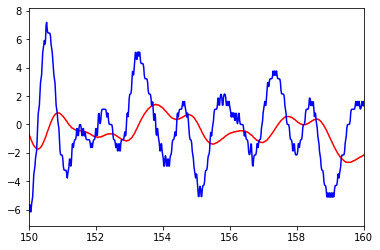

In [5]:
x = np.abs(np.squeeze(annots['bin_pos']))
x = x.astype(float)
x = (x-np.mean(x))/np.std(x)
dt = 1./60
T=np.squeeze(annots['diode_BT'])
v = ndimage.gaussian_filter1d(x, sigma=1, order=1, mode='wrap') / dt
#v = np.diff(x)/dt
x=x[1:-1]
v=v[1:-1] #cut ends.  V(n) = X(n) -X(n-1)
T=T[1:-1]
#plt.plot(T,L[1:-1], 'm-')
plt.plot(T,x, 'r-')
plt.plot(T,v, 'b-')
plt.xlim(150,160)

In [6]:
x_cor = np.correlate(x, x, "same")
x_cor = x_cor[:int((len(x_cor)+1)/2)+1]
Taxis = np.flip(T[:len(x_cor)]-dt/2)
t_cor = np.interp(0.5*max(x_cor),  x_cor, Taxis)
t_cor

0.7267072741670553

In [7]:
realr, edges = np.histogram(annots['reconstruct_spikes'][0][channelnumber], np.append(0,T))
realr[np.where(realr >= 1)] = 1
np.unique(realr)

array([0, 1], dtype=int64)

In [8]:
(len(realr)-(np.shape(np.where(realr==0))[1]))/len(realr) #non-zero state percentage

0.10119973339257943

In [9]:
deltaT = 0.5
r = x+v*deltaT
rstate = Fake_Spike_Activation_function(realr, r, 'burst distributed', ['randomly not fire'])

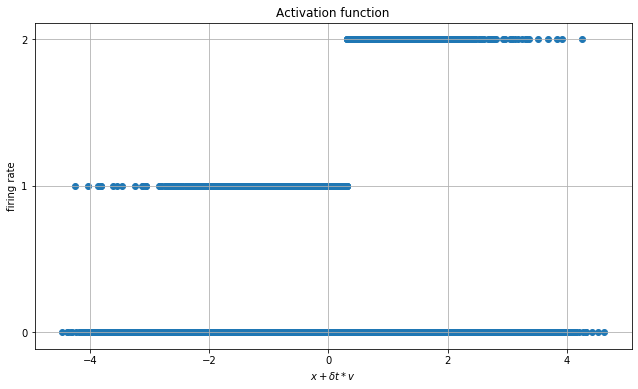

In [10]:
plt.scatter(r, rstate)
plt.title('Activation function')
plt.gcf().set_size_inches(10.7, 6)
# plt.xticks(edges, [r'$min$', r'$\mu+\sigma$',r'$\mu+2*\sigma$',r'$\mu+3*\sigma$'])
plt.yticks(np.unique(rstate))
plt.ylabel('firing rate')
plt.xlabel(r'$x+\delta t*v$')
plt.grid(True)

C:\Users\hydro_leo\Documents\GitHub\python-code\PIfunc.py:55: RuntimeWarning: divide by zero encountered in log2
  MIxvR[i]=np.nansum(pxvr*np.log2(pxvr/pxv/pr))/dt
C:\Users\hydro_leo\Documents\GitHub\python-code\PIfunc.py:55: RuntimeWarning: invalid value encountered in multiply
  MIxvR[i]=np.nansum(pxvr*np.log2(pxvr/pxv/pr))/dt
C:\Users\hydro_leo\Documents\GitHub\python-code\PIfunc.py:53: RuntimeWarning: divide by zero encountered in log2
  MIxr[i]=np.nansum(pxr*np.log2(pxr/px/pr))/dt
C:\Users\hydro_leo\Documents\GitHub\python-code\PIfunc.py:53: RuntimeWarning: invalid value encountered in multiply
  MIxr[i]=np.nansum(pxr*np.log2(pxr/px/pr))/dt
C:\Users\hydro_leo\Documents\GitHub\python-code\PIfunc.py:57: RuntimeWarning: divide by zero encountered in log2
  PI_xR = np.nansum(pxr*np.log2(pxr/px/pr), axis = (0,1))
C:\Users\hydro_leo\Documents\GitHub\python-code\PIfunc.py:57: RuntimeWarning: invalid value encountered in multiply
  PI_xR = np.nansum(pxr*np.log2(pxr/px/pr), axis = (0,1))


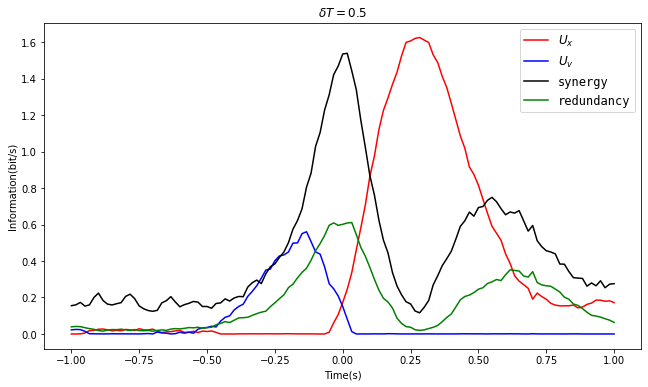

In [11]:
#rstate = np.random.poisson(rstate)
xstate, edges = EqualState(x, 6)
vstate, edges = EqualState(v, 6)
#calculate information
window = [-1,1] # second
timeshift, MIx, MIv, MIjoint, Redun = PIfunc(rstate, xstate, vstate, dt, window)
Ux = MIx-Redun
Uv = MIv-Redun
Syner = MIjoint-MIx-MIv+Redun
#plot PI
plt.plot(timeshift,Ux, 'r-')
plt.plot(timeshift,Uv, 'b-')
plt.plot(timeshift,Syner, 'k-')
plt.plot(timeshift,Redun, 'g-')
plt.title(r'$\delta T=$'+str(deltaT))
plt.xlabel('Time(s)')
plt.ylabel('Information(bit/s)')
plt.gcf().set_size_inches(10.7, 6)
plt.legend( (r'$U_x$', r'$U_v$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})
plt.show()

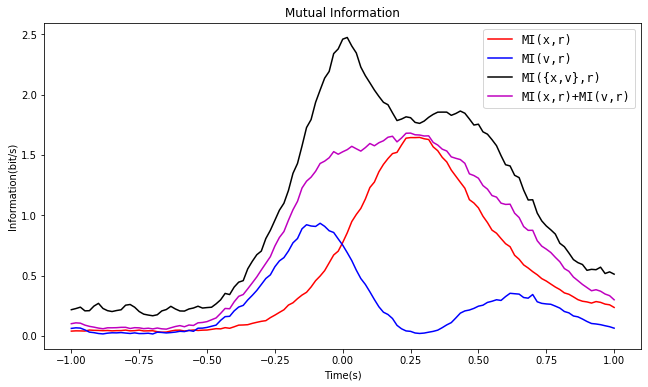

In [12]:
#plot MIs
plt.plot(timeshift,MIx, 'r-')
plt.plot(timeshift,MIv, 'b-')
plt.plot(timeshift,MIjoint, 'k-')
plt.plot(timeshift,MIx+MIv, 'm-')
plt.title('Mutual Information')
plt.xlabel('Time(s)')
plt.ylabel('Information(bit/s)')
plt.gcf().set_size_inches(10.7, 6)
plt.legend( ('MI(x,r)', 'MI(v,r)', 'MI({x,v},r)', 'MI(x,r)+MI(v,r)'), loc='best', prop={'size': 'large', 'family': 'monospace'})
# plt.savefig(str(deltaT)+'_fake_spike_MI.tiff')

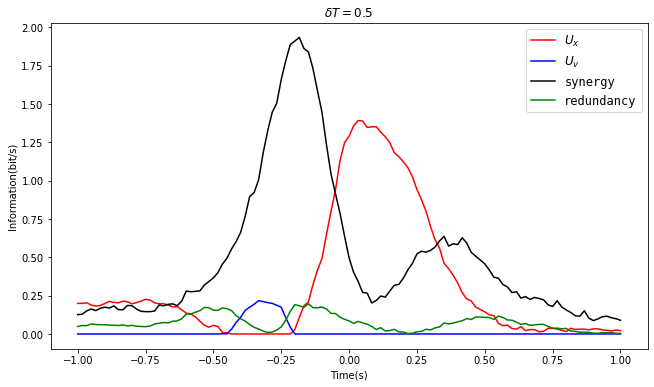

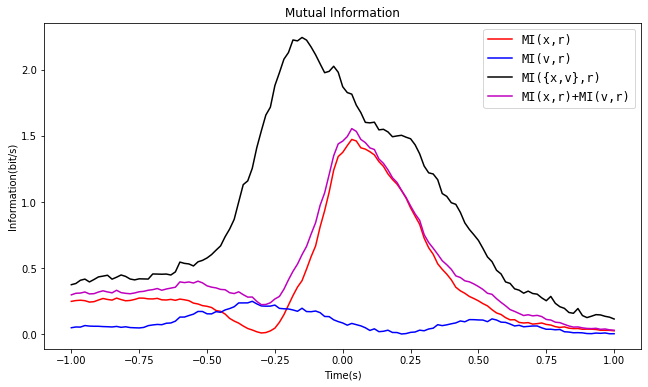

In [13]:
timeshift, MIx, MIv, MIjoint, Redun = PIfunc(realr, xstate, vstate, dt, window)
Ux = MIx-Redun
Uv = MIv-Redun
Syner = MIjoint-MIx-MIv+Redun
#plot PI
plt.plot(timeshift,Ux, 'r-')
plt.plot(timeshift,Uv, 'b-')
plt.plot(timeshift,Syner, 'k-')
plt.plot(timeshift,Redun, 'g-')
plt.title(r'$\delta T=$'+str(deltaT))
plt.xlabel('Time(s)')
plt.ylabel('Information(bit/s)')
plt.gcf().set_size_inches(10.7, 6)
plt.legend( (r'$U_x$', r'$U_v$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})
plt.show()
#plot MIs
plt.plot(timeshift,MIx, 'r-')
plt.plot(timeshift,MIv, 'b-')
plt.plot(timeshift,MIjoint, 'k-')
plt.plot(timeshift,MIx+MIv, 'm-')
plt.title('Mutual Information')
plt.xlabel('Time(s)')
plt.ylabel('Information(bit/s)')
plt.gcf().set_size_inches(10.7, 6)
plt.legend( ('MI(x,r)', 'MI(v,r)', 'MI({x,v},r)', 'MI(x,r)+MI(v,r)'), loc='best', prop={'size': 'large', 'family': 'monospace'})
# plt.savefig(str(deltaT)+'_fake_spike_MI.tiff')

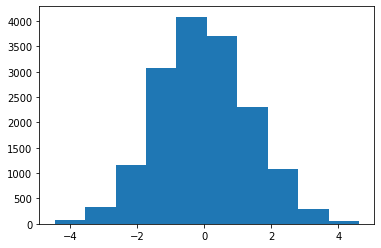

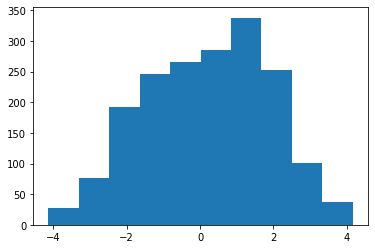

In [14]:
for n in np.unique(realr):
    fig, ax = plt.subplots()
    hst = ax.hist(r[np.where(realr == n)])

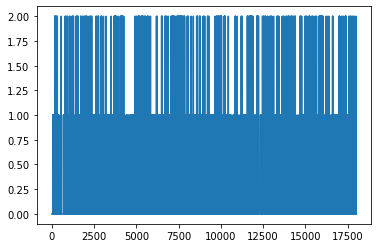

In [15]:
plt.plot(rstate)

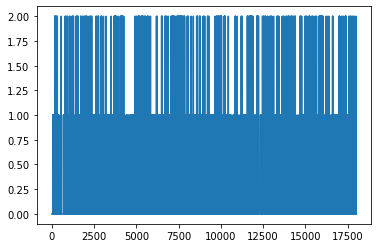

In [16]:
plt.plot(rstate)